# Purpose:

1) explore appropriate labels for the data

2) explore reviews to determine hyperparams for deployment

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
import matplotlib.pyplot as plt

In [2]:
!ls ../datasets/classification/

drugsComTest_raw.tsv  drugsComTrain_raw.tsv


In [3]:
df = pd.DataFrame.from_csv('../datasets/classification/drugsComTrain_raw.tsv', sep='\t')

/home/itq/.virtualenvs/test/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [4]:
df.tail()

,drugName,condition,review,rating,date,usefulCount
191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10.0,"May 31, 2015",125
127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1.0,"November 1, 2011",34
187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2.0,"March 15, 2014",35
47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10.0,"September 19, 2015",79
215220,Lubiprostone,"Constipation, Chronic","""I&#039;ve had chronic constipation all my adu...",9.0,"December 13, 2014",116


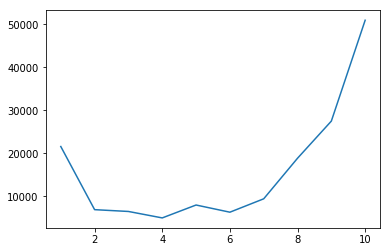

In [5]:
rating = df.rating.value_counts()
rating_sort = rating.sort_index()
rating_sort.plot()

# Determining Labels

- determine what proportion to classify on

- ratings from 1-10. Do we want all 10? Probably not

# Observation

1) The dataset is crazy imbalanced. We might want to try predicting on accumulated values

2) The number of 10 ratings is far higher. We can try and do some EDA to modify the objective

In [6]:
normalized_rating_counts = rating_sort / max(rating_sort)

In [7]:
normalized_rating_counts.cumsum()

1.0     0.423993
2.0     0.559925
3.0     0.687658
4.0     0.785954
5.0     0.943105
6.0     1.067505
7.0     1.252957
8.0     1.623429
9.0     2.163369
10.0    3.163369
Name: rating, dtype: float64

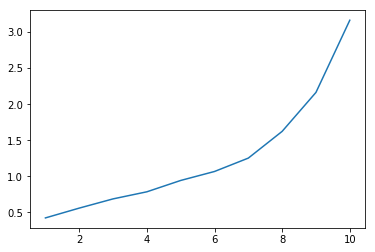

In [8]:
normalized_rating_counts.cumsum().plot()

# Observation 2

1) Looks like we can split the dataset into 3 groups: bad (1-6), acceptable (7-9), and excellent (10)

In [9]:
def create_labels(new_df):
    new_df = df.copy()
    new_df['label'] = 0
    new_df.loc[df['rating'] < 7, 'label'] = 0
    new_df.loc[np.logical_and(df['rating'] >= 7, df['rating'] < 10), 'label'] = 1
    new_df.loc[df['rating'] == 10, 'label'] = 2
    return new_df

labelled_data = create_labels(df)

In [10]:
labelled_data['label'].value_counts()

1    55877
0    54431
2    50989
Name: label, dtype: int64

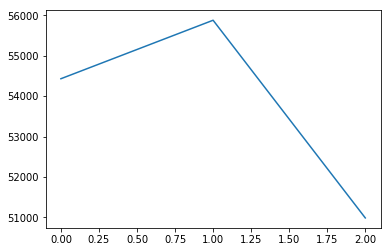

In [11]:
%matplotlib inline
labelled_data.label.value_counts().sort_index().plot()

# Input exploration

## Goals

- explore features

## Steps:

1) remove stopwords (as in NLTK)

2) Tokenize via treebank tokenizer

3) lemmatize as in wordnetlemmatizer

4) TFIDF features + saving them

In [12]:
features_series = df.review

In [13]:
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
import re

from sklearn.feature_extraction.text import TfidfVectorizer
import pickle 

In [16]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.add('``')  # First character
def text_prepare(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = GOOD_SYMBOLS_RE.sub('', text)
    text = ' '.join([lemmatizer.lemmatize(x) for x in tokenizer.tokenize(text) if x and x not in STOPWORDS])
    return text.strip()

In [17]:
tokenizer = TreebankWordTokenizer()
lemmatizer = WordNetLemmatizer()
STOPWORDS = set(stopwords.words('english'))

vectorizer = TfidfVectorizer(preprocessor=text_prepare, ngram_range=(0,2))

In [18]:
transformed_features = vectorizer.fit_transform(df.review.tolist())

In [19]:
with open('vectorizer.pk', 'wb') as fin:
    pickle.dump(vectorizer, fin)

In [20]:
transformed_features

<161297x1502407 sparse matrix of type '<class 'numpy.float64'>'
	with 12708673 stored elements in Compressed Sparse Row format>

In [24]:
def feature_transform(input_data, transformer):
    
    # y's construction
    new_df = df.copy()
    new_df['label'] = 0
    new_df.loc[df['rating'] < 7, 'label'] = 0
    new_df.loc[np.logical_and(df['rating'] >= 7, df['rating'] < 10), 'label'] = 1
    new_df.loc[df['rating'] == 10, 'label'] = 2
    
    
    
    # X's construction
    features = transformer.fit_transform(new_df.review.tolist())
    labels = new_df['label']
    
    return features, labels

In [25]:
processed_data = feature_transform(df, vectorizer)

AttributeError: 'tuple' object has no attribute 'head'